In [1]:
from Pers_utils.Ramp import Ramp
from cPers_utils.cPixTraps import cPixTraps as PixTraps
import matplotlib.pyplot as plt
import numpy as np
from Pers_utils.GeneralRandom import GeneralRandom
from scipy.stats import beta,powerlaw
import time

%matplotlib notebook

<IPython.core.display.Javascript object>


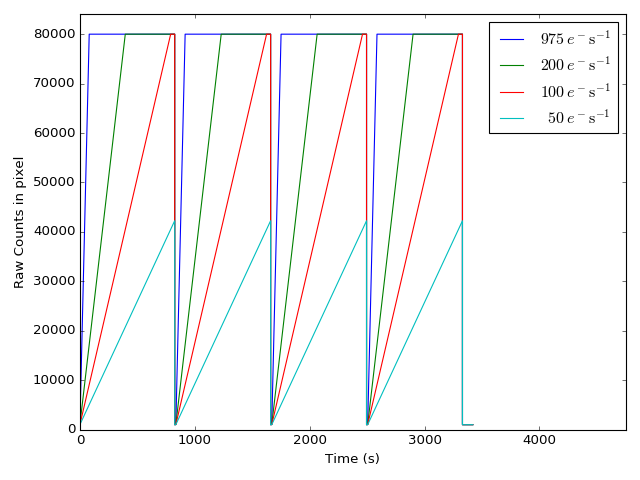

In [2]:
#Create test ramps and plot them

plt.close("all")

myramp1 = Ramp(975,825,4,57*60)
myramp1.test_plot(label=r'$975 \,e^-\mathrm{s^{-1}}$')

myramp2 = Ramp(200,825,4,57*60)
myramp2.test_plot(label=r'$200 \,e^-\mathrm{s^{-1}}$')

myramp3 = Ramp(100,825,4,57*60)
myramp3.test_plot(label=r'$100 \,e^-\mathrm{s^{-1}}$')

myramp4 = Ramp(50,825,4,57*60)
myramp4.test_plot(label=r'$ \;\;50 \,e^-\mathrm{s^{-1}}$')

plt.xlim(0,4.75e3)
plt.legend()
plt.tight_layout()

<IPython.core.display.Javascript object>


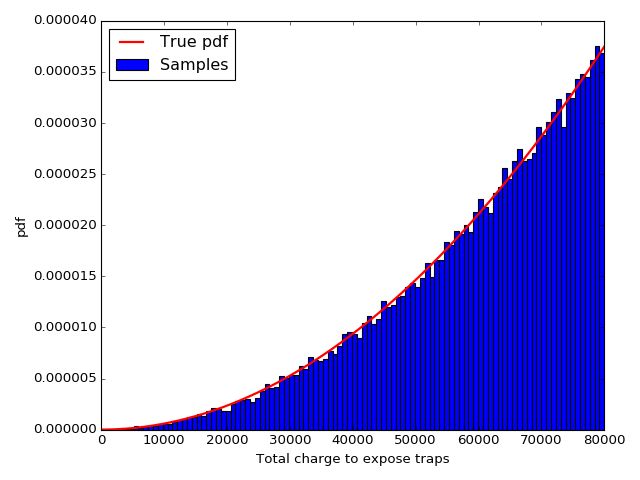

In [3]:
# Initialize the pixel(s) traps distribution
# as a function of accumulated charge 
# (i.e. this is the density of traps that are exposed to free
# charge at a given total charge level)

alpha = 2
ntraps = 5e4

rhotrap_dist = powerlaw(alpha+1,scale=80000)
x = np.arange(80000)
y = rhotrap_dist.pdf(x)

rhotrap = (rhotrap_dist.rvs(size=ntraps)).astype(np.int)
plt.close("all")
plt.hist(rhotrap,bins=100,normed=True,label='Samples');
plt.xlabel('Total charge to expose traps')
plt.ylabel('pdf')
plt.plot(x,y,label="True pdf",c='r',linewidth=2)
plt.legend(loc=2)
plt.tight_layout()

<IPython.core.display.Javascript object>


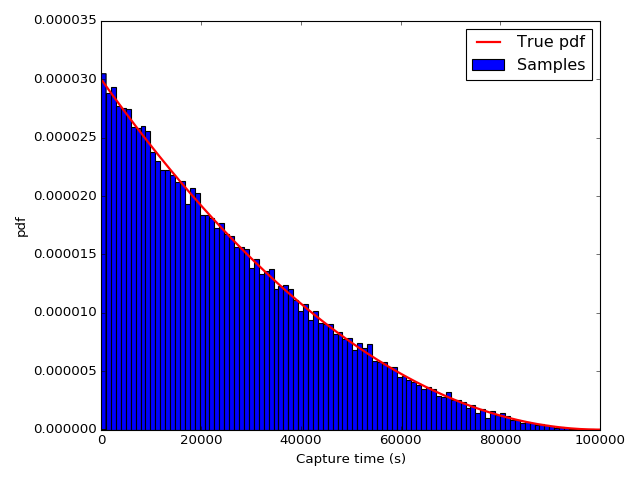

In [4]:
# Initialize the pixel(s) traps capture time distribution
# assume that release times are proportional to capture times

abeta = 1.
bbeta = 3
tmin  = 1
tmax  = 1e5

tcap_dist = beta(abeta,bbeta,loc=tmin,scale=tmax-tmin)
x = np.arange(tmin,tmax)
y = tcap_dist.pdf(x)

tcap = tcap_dist.rvs(size=ntraps)
plt.close("all")
plt.hist(tcap,bins=100,label='Samples',normed=True);
plt.plot(x,y,label='True pdf',c='r',linewidth=2)

plt.legend(loc=1)
plt.xlabel('Capture time (s)')
plt.ylabel('pdf')
plt.tight_layout()

In [5]:
# Use these distributions to initialize the pixel

mypixel = PixTraps(tcap,10*tcap,rhotrap)

<IPython.core.display.Javascript object>


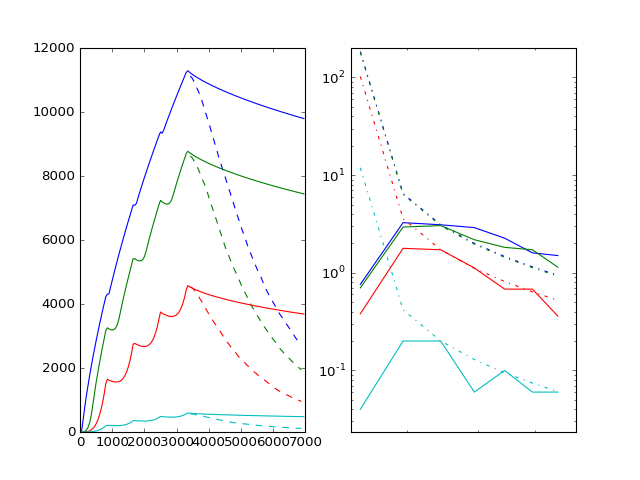

Elapsed_time (min) 5.222105033333336


In [35]:
# Test the differential method
plt.close("all")

times  = np.arange(0,7000,50)
tafter = np.arange(0,3500,50)

f   = plt.figure()
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

time0 = time.process_time()
ramps = [myramp1,myramp2,myramp3,myramp4]
sml   = 10

for ramp in ramps:
    mypixel.reset()
    op = mypixel.follow_occ_prob(ramp,times)
    tp = np.sum(op,axis=0)
    ch = mypixel.get_trapped_charge_diff(ramp,tafter)
 
    x = ax1.plot(times,tp)
    color=x[0].get_color()
    ax1.plot(tafter+ramp.rtime[-1],ch,'--',color=color)
    dcdt = -1.*(ch[1::sml]-ch[:-1:sml])/(tafter[1::sml]-tafter[:-1:sml])
    dtcen = 0.5*(tafter[1::sml]+tafter[:-1:sml])
    ax2.plot(ramp.rtime[-1]+dtcen,dcdt,color=color)
    # Comapre to a power-law decay
    t0 = 1000
    gamma = 1.1
    ii = np.argmin(np.abs(dtcen-t0))
    t0 = dtcen[ii]
    Ak = dcdt[ii]*(t0**gamma)
    
    ax2.plot(ramp.rtime[-1]+dtcen,Ak*dtcen**(-1.*gamma),'-.',color=color)
    
    
el_t = (time.process_time() - time0)/60
print('Elapsed_time (min)',el_t)
ax2.set_yscale('log')
ax2.set_xscale('log')



In [7]:
#Run the pixel through each ramp
#and get the persistence accumulated charge

time0 = time.process_time()
ramps   = [myramp1,myramp2,myramp3,myramp4]

times  = np.arange(0,7000,10)
charges = []
totfills = []

for ramp in ramps:
    mypixel.reset()
    mypixel.end_ramp_occ(ramp)
    totfills.append(mypixel.totfill)
    print('Total number of filled traps','%.0f' %totfills[-1][-1])
    charges.append(mypixel.get_trapped_charge(times))

    
el_t = (time.process_time() - time0)/60
print('Elapsed_time (min)',el_t)

Total number of filled traps 11159
Total number of filled traps 8721
Total number of filled traps 4549
Total number of filled traps 567
Elapsed_time (min) 12.749861166666667


<IPython.core.display.Javascript object>


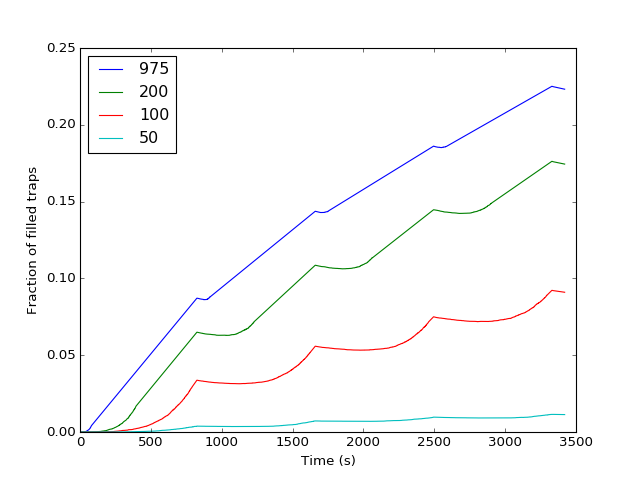

In [23]:
#Plot the evolution of the number of filled traps
plt.close("all")
for z in zip(ramps,totfills):
    plt.plot(z[0].rtime[1:],z[1]/ntraps,label=('%.0f' %z[0].rate))
    
plt.legend(loc=2)
plt.ylabel('Fraction of filled traps')
plt.xlabel('Time (s)')

<IPython.core.display.Javascript object>


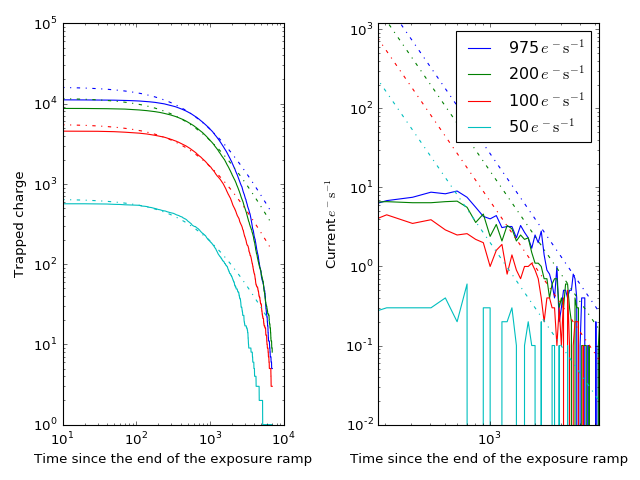

In [34]:
plt.close("all")


nrows = len(ramps)

f =  plt.figure()

ax1=f.add_subplot(121)
ax2=f.add_subplot(122)

for i,z in enumerate(zip(ramps,charges,totfills)):

    ramp = z[0]
    charge = z[1]
    totfill_end = z[2][-1]
    #print('%.0f' %ramp.rate)

    ############
    #Charge plot
    ############

    x = ax1.plot(times,charge)
    color=x[0].get_color()
#   ax1.plot(times,np.repeat(totfill_end,len(times)),'--',color=color)

    #Compare to power-law decay by making them agree at time t0 (current goes like t^-gamma)
    gamma = 2.75
    t0 = 1000
    tnorm = 1000

    ii     = np.argmin(np.abs(times-tnorm))
    tnormh = times[ii]    
    Qnorm  = charge[ii]
    Qplconst = Qnorm/(tnormh+t0)**(1-gamma)

    
    
#    Apl   = charge[ii]*(gamma-1)/((times[ii]+t0)**(1-gamma) - t0**(1-gamma))
#    pldecay = -1.* Apl/(1-gamma) * ((times+t0)**(1-gamma)-t0**(1-gamma))  
#    pldecay = mp-pldecay
    
    ax1.plot(times,Qplconst*(times+t0)**(1-gamma),'-.',color=color)


    ############
    #Current plot
    ############

    # Get a count rate
    sml  = 10
    dcdt = -(charge[1::sml]-charge[:-1:sml])/(times[1::sml]-times[:-1:sml])
    dtcen = 0.5*(times[1::sml]+times[:-1:sml])

    ii    = np.argmin(np.abs(dtcen-tnorm))

    tnormh = dtcen[ii]    
    Cnorm  = dcdt[ii]
    Cplconst = Cnorm/(tnormh+t0)**(-gamma)
    ax2.plot(dtcen,dcdt,color=color,label=(('%.0f' %ramp.rate) + r'$\,e^-\mathrm{s^{-1}}$'))
    ax2.plot(dtcen,Cplconst*dtcen**(-gamma),'-.',color=color)


ax1.set_xlabel("Time since the end of the exposure ramp")
ax1.set_ylabel('Trapped charge')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax2.set_xlabel("Time since the end of the exposure ramp")
ax2.set_ylabel('Current'+ r'$\,e^-\mathrm{s^{-1}}$')
ax2.set_xlim(100,times[-1])
ax2.set_yscale('log')
ax2.set_xscale('log')

plt.legend()
plt.tight_layout()